## **Lab 10**

## **Sai Tallapragada**

## **3/30/2021**

# **Introduction**

In this lab, we are trying to understand the month to month changes that are occuring in the thickness of Artic and Antartic sea-ice through using two different univariate time series models. The two univariate time series models we use in this lab are ARIMA and SARIMA models. We will be training our models on data prior to 2010 and we will try to predict the overall ie thickness of sea ice after 2010. We will then compare our predictions to the the actual data values after 2010 form our test dataset.

# **Data**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#Loading data into dataframe to be used,combine all 12 csv files into one dataframe so we have proper dataset with all 12 months
df = pd.concat(map(pd.read_csv, ['N_01_extent_v3.0.csv', 'N_02_extent_v3.0.csv','N_03_extent_v3.0.csv','N_04_extent_v3.0.csv',                         
                                 'N_05_extent_v3.0.csv','N_06_extent_v3.0.csv','N_07_extent_v3.0.csv'     
                                 ,'N_08_extent_v3.0.csv','N_09_extent_v3.0.csv','N_10_extent_v3.0.csv','N_11_extent_v3.0.csv' ,'N_12_extent_v3.0.csv']))
#remove the spaces that appear in column headings
df.columns = df.columns.str.replace(' ', '') 
#dropping bad rows from dataset
df = df[df['area'] != -9999.00]
#dropping columns we don't need
df=df.drop(['data-type','region','extent'], axis=1)
#create a unique time column to sort on
df["time"] = df["year"].apply(str) + "-" + df["mo"].apply(str).str.zfill(2)
#drop the old columns we don't need now
df=df.drop(['year', 'mo'], axis=1)
#make sure our new unique column is the index which is important for time series data (needs to be in order!)
df = df.set_index('time')
#sort it!
df = df.sort_values(by=['time'])
#make sure it's in order
df.head(50)

,area
time,
1978-11,9.04
1978-12,10.90
1979-01,12.41
1979-02,13.18
1979-03,13.21
1979-04,12.53
1979-05,11.11
1979-06,9.34
1979-07,6.69


We got the csv files we imported from the following Source: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/.

# **Exploratory Data Analysis**

In [ ]:
df.head()

,area
time,
1978-11,9.04
1978-12,10.90
1979-01,12.41
1979-02,13.18
1979-03,13.21


In [ ]:
df.isnull().values.any()

False

In [ ]:
df.shape

(505, 1)

Based on the df.head that is displayed above, we are working with only one main column for data values and that is the area column which has the ice thickness. We also don't have any null values in the data according to the output of the code cell above. There also seems to be about 505 total data samples where each sample is from one month.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


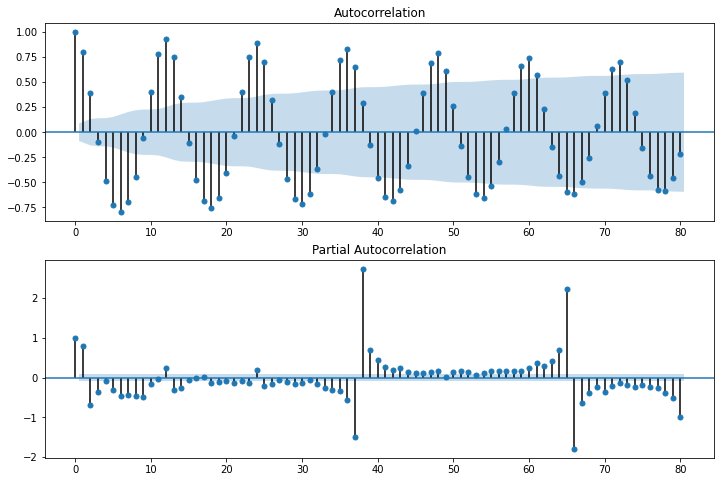

In [ ]:
# Plotting ACF and PACF
import statsmodels.api as sm
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["area"].diff().dropna(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["area"].diff().dropna(), lags=80, ax=ax2)
plt.show()


The amplitude of Autocorrelation plot seems to gradually tail off as the lags keep increasing after 70. However, the parital correlation does not seem to be tailing off so I would assume that is is a cut off at some later point. Thus, I believe that the model order should be a AR(p) model. however, if the amplitude of the particial correlation function plot tails off at a certain later point, then we would have a ARMA(p,q) model.

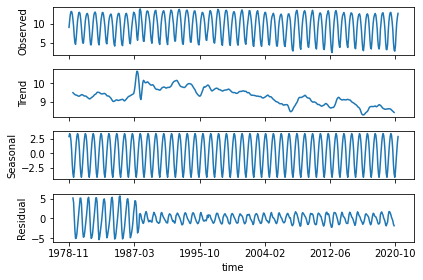

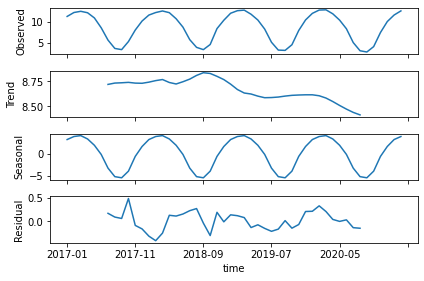

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df, freq=12).plot()
seasonal_decompose(df[-50:], freq=12).plot()
plt.show()                                  

Based on the graphs above, the overall trend seems to be a gradual decrease in terms of the thickness of sea ice where we can aboverve that the average thickness of ice goes from a value in 10 in the 1980s to a value of 8.50 as off 2020. Further more, seasonal plot indicates that there are increases and decreses in the thickness of sea ice depnding on the seasons throughout the year as it is cyclic in a fixed period according to the plots above.  

In [ ]:
traindata, testdata = df.iloc[:371,0], df.iloc[371:,0]
print(traindata.tail())
print(testdata.tail())
testdata.head()


time
2009-08     4.16
2009-09     3.76
2009-10     5.24
2009-11     8.36
2009-12    10.59
Name: area, dtype: float64
time
2020-10     4.08
2020-11     7.49
2020-12    10.13
2021-01    11.71
2021-02    12.71
Name: area, dtype: float64


time
2010-01    12.04
2010-02    12.96
2010-03    13.53
2010-04    12.85
2010-05    10.88
Name: area, dtype: float64

In [ ]:
#We are Splitting our training and testing data for our models later.
train, test = df.iloc[:371,0], df.iloc[371:,0]

The training dataset consists of of values measured before 2010 and the testing dataset consists of all the values measured in 2010 and after.

In [ ]:
test.index

Index(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10',
       ...
       '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
       '2020-11', '2020-12', '2021-01', '2021-02'],
      dtype='object', name='time', length=134)

# **Models**

### **ARIMA**


I used the following source to write code for the ARIMA model. [Source](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).

In [ ]:
pip install pmdarima

I used the following code to get the code in the cell below: https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

The code below is being used to find the right order parameter to use in our ARIMA model.

In [ ]:


# Import the library
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=485.390, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=903.599, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=570.355, Time=1.02 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=630.910, Time=1.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=901.644, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=515.410, Time=0.30 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=483.321, Time=2.19 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=481.709, Time=1.16 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=483.496, Time=3.23 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=484.922, Time=8.41 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=629.531, Time=1.38 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=374.262, Time=1.90 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=435.279, Time=0.53 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=374.312, Time=6.26 sec
 ARIMA(2,0,1)(1,1,1)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  371
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -178.743
Date:                            Wed, 31 Mar 2021   AIC                            367.485
Time:                                    03:54:44   BIC                            386.902
Sample:                                         0   HQIC                           375.206
                                            - 371                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5406      0.027     57.281      0.000       1.488       1.593
ar.L2         -0.8262      0.023    -36.201      0.000      -0.871      -0.781
ma.L1         -0.3579      0.049     -7.363      0.000      -0.453      -0.263
ma.S.L12      -0.4749      0.033    -14.479      0.000      -0.539      -0.411
sigma2         0.1563      0.005     30.654      0.000       0.146       0.166
===================================================================================
Ljung-Box (Q):                       58.10   Jarque-Bera (JB):              1949.66
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Code cells above are used to find the recommened order to use when make our arima model below. 

In [ ]:
#I am using (3,0,0) because it has a lowest AIC
model = ARIMA(train, order=(3,0,0))
res = model.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                   area   No. Observations:                  371
Model:                     ARMA(3, 0)   Log Likelihood                -320.055
Method:                       css-mle   S.D. of innovations              0.569
Date:                Wed, 31 Mar 2021   AIC                            650.109
Time:                        03:57:42   BIC                            669.690
Sample:                             0   HQIC                           657.886
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4671      0.096     98.691      0.000       9.279       9.655
ar.L1.area     1.5707      0.052     30.298      0.000       1.469       1.672
ar.L2.area    -0.7939      0.088     -9.042      0.0

In [ ]:
pred=res.predict(start=371, end =504) #We are had to set the type ot something not linear because we are not dealing with linear data.
predictions=pred
predictions

371    12.471297
372    13.388916
373    13.145863
374    11.874680
375     9.992540
         ...    
500     9.555752
501     9.514394
502     9.461938
503     9.413855
504     9.383514
Length: 134, dtype: float64

Below, we are going to be plotting the predicted and the observed values for all the months during and after 2010.

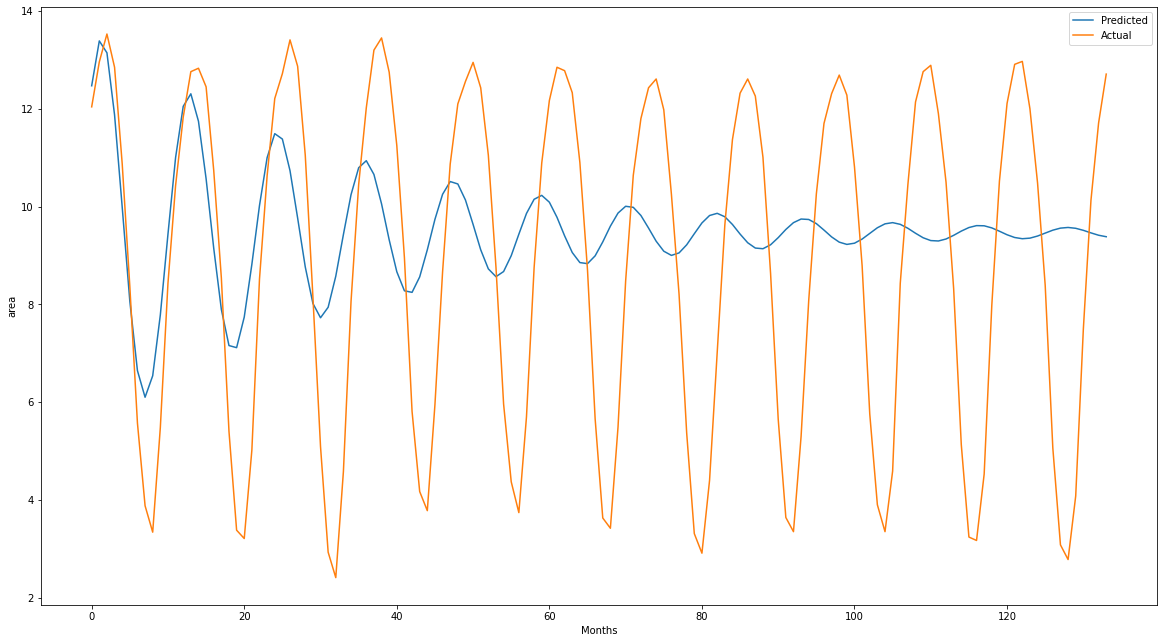

In [ ]:
plt.plot(range(len(predictions)), predictions, label='Predicted')
plt.plot(range(len(test)), test, label='Actual')
plt.rcParams["figure.figsize"] = (20,11)
plt.legend()
plt.xlabel('Months')
plt.ylabel('area')
plt.show() 

Based off the results above, the Arima model was not able to make very good predictions dates for values after 2010. We can see that it was not able to make a multi step out of sample prediction for the values even though it was fitted using training data from 370 different months prior to 2010. The BIC values and AIC vlaues will be discussed later in the conclusion to compare the two different models we use in the lab. We are able to make average predictions in the beginning but the amplitude decreases as we keep making more and more out of sample predictions.

### **SARIMA**

I looked at the following sources for writting code for this section. [Source1](https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/)

In [ ]:
# The code used in this cell will hep us find the optimal parametes to use for the order.

import itertools
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)


In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,order=(0,1,1),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               area   No. Observations:                  371
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -259.833
Date:                            Tue, 30 Mar 2021   AIC                            525.665
Time:                                    07:28:58   BIC                            537.187
Sample:                                         0   HQIC                           530.254
                                            - 371                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4135      0.024     17.545      0.000       0.367       0.460
ma.S.L12      -0.3344      0.028   

In [ ]:
predictions=results.predict(start=371,end=505)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Below, we are going to be plotting the predicted and the observed values for all the months during and after 2010.

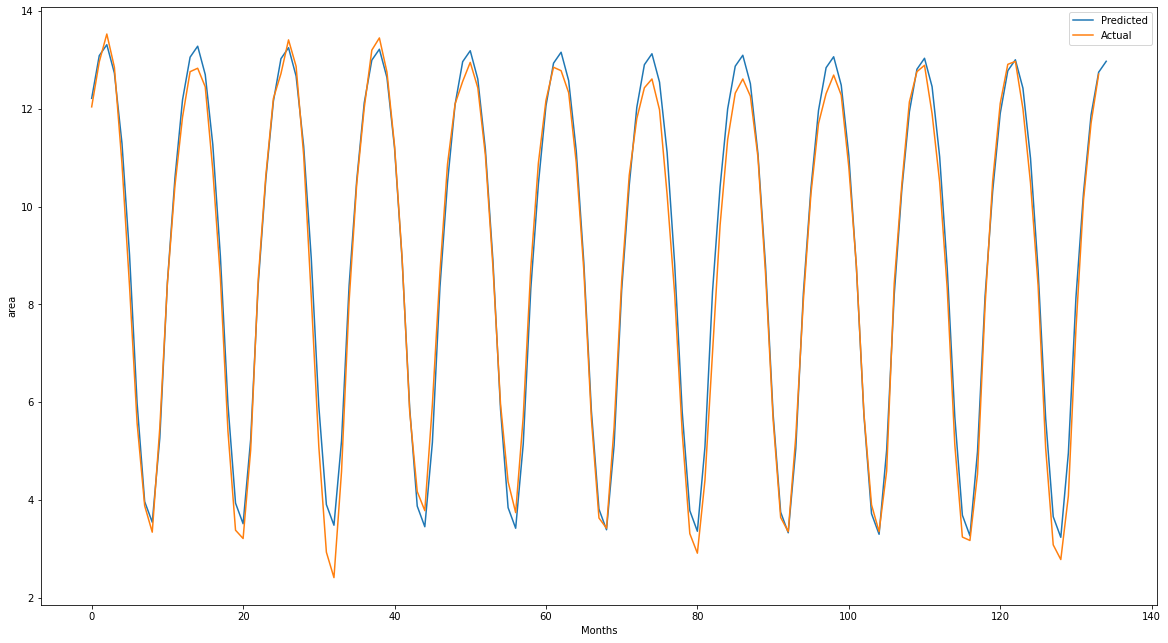

In [ ]:
plt.plot(range(len(predictions)), predictions, label='Predicted')
plt.plot(range(len(test)), test, label='Actual')
plt.rcParams["figure.figsize"] = (20,11)
plt.legend()
plt.xlabel('Months')
plt.ylabel('area')
plt.show() 

Visuallly, we can see that thhe out of sample multi-step predictions made by the SARIMA model were able to accurately follow the observed values(true values) of the thickness of sea ice after 2010. The predictions seem to be underpredicting in the valleys and sometimes over predicting the peaks of the plot.

# **Conclusion**

In our lab, we trained the ARIMA and the SARIMA time series models and made out of sample multi-step predictions with both the models. According to the results above, the ARIMA model did not do so well as the output for the model showed that the amplitude of the predicted values was decreasing as more out of sample predictions were being made by the ARIMA model. This could perhaps be with the way we chose the parameters. Furthermore, the SARIMA model seems to be the better model in comparision to ARIMA for multi-step out of sample predictions as the AIC and BIC values for SARIMA was lower than the AIC and BIC values for ARIMA. This shows us that the SARIMA is more like to be the closer or the more of the true model in comparision to the ARIMA model. Our results also indicated that our SARIMA because the visual outputs showed that the SARIMA model performed better than the ARIMA model as the predicted values followed the obeserved value pretty closely for the SARIMA model whereas the ARIMA model gradually made worse predictions as it kept making more out of sample predictions. Overall, the SARIMA model was th ebtter of the two models we trained in the lab and we could firther imporve upon the results we get by choosing better parameters for ARIMA in the future iterations.